# Set up

In [2]:
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *

setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

# Model 2: SSH input only

# Prepare training data for normalization statistics (SSH only)
x_train_ssh_only = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_normalized_ssh, min_vals_ssh, max_vals_ssh = min_max_normalize(x_train_ssh_only)

# Prepare test data (SSH only)
x_test_ssh_only_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_normalized_ssh, _, _ = min_max_normalize(x_test_ssh_only_original, min_vals_ssh, max_vals_ssh)

# Create test dataset and loader
test_dataset_ssh = TensorDataset(x_test_normalized_ssh, y_test)
test_loader_ssh = DataLoader(test_dataset_ssh, batch_size=32, shuffle=False)

# Load model
model_ssh_only = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model_ssh_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_location=device)
model_ssh_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_ssh_only.eval()
results_ssh_only = {
    'ssh': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices_ssh = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_ssh):
        
        batch_start = i * test_loader_ssh.batch_size
        batch_end = min(batch_start + test_loader_ssh.batch_size, len(test_dataset_ssh))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_ssh.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_ssh_only(batch_x)
        
        ssh_batch_original = x_test_ssh_only_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_ssh_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_ssh_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_ssh_only['bm_true'].append(bm_true.cpu().numpy())
        results_ssh_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_ssh_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_ssh_only['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_ssh_only['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_ssh_only:
    results_ssh_only[key] = np.concatenate(results_ssh_only[key], axis=0)

print("Model 2 evaluation complete!")

# Model 3: MSE loss only
model_mse_only = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_mse_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_location=device)
model_mse_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_mse_only.eval()
results_mse_only = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': []
}

sample_indices_mse = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):  
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_mse.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_mse_only(batch_x)
        
        # Use original scale SSH and SST for BM calculation
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # For MSE model, only use mean prediction (no sampling)
        mu_zca_expanded = outputs[:, 0:1, ...]  # Use first channel as mean
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Store results
        results_mse_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_mse_only['sst'].append(sst_batch_original.cpu().numpy())
        results_mse_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_mse_only['bm_true'].append(bm_true.cpu().numpy())
        results_mse_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_mse_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())

for key in results_mse_only:
    results_mse_only[key] = np.concatenate(results_mse_only[key], axis=0)

print("Model 3 evaluation complete!")

# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    ('ssh_only', results_ssh_only, True, False), 
    ('mse_only', results_mse_only, False, True)
]


Using device: cpu
Model 1 evaluation complete!
Model 2 evaluation complete!
Model 3 evaluation complete!


In [4]:
# Store all datasets
eval_datasets = {}


def create_evaluation_dataset(results, model_name, has_ensembles=True, has_sst=True, stochastic_samples=300):
    """Create xarray dataset from evaluation results"""
    n_samples = results['ssh'].shape[0]
    H, W = results['ssh'].shape[2], results['ssh'].shape[3]
    
    # Create base coordinate arrays
    coords = {
        'sample': range(n_samples),
        'i': range(H),
        'j': range(W)
    }
    
    # Add stochastic_sample coordinate if we have ensembles
    if has_ensembles and 'ubm_pred_ensembles' in results:
        coords['stochastic_sample'] = range(stochastic_samples)
    
    # Create data variables
    data_vars = {
        'ssh': (['sample', 'i', 'j'], results['ssh'].squeeze(1)),
        'ubm_truth': (['sample', 'i', 'j'], results['ubm_true'].squeeze(1)),
        'bm_truth': (['sample', 'i', 'j'], results['bm_true'].squeeze(1)),
        'ubm_pred_mean': (['sample', 'i', 'j'], results['ubm_pred_mu'].squeeze(1)),
        'bm_pred_mean': (['sample', 'i', 'j'], results['bm_pred_mu'].squeeze(1))
    }
    
    # Add SST if available
    if has_sst and 'sst' in results:
        data_vars['sst'] = (['sample', 'i', 'j'], results['sst'].squeeze(1))
    
    # Add ensemble results if available
    if has_ensembles and 'ubm_pred_ensembles' in results:
        print(f"Adding ensemble data with shape: {results['ubm_pred_ensembles'].shape}")
        # Fix: squeeze the extra channel dimension (index 2)
        data_vars['ubm_pred_samples'] = (['sample', 'stochastic_sample', 'i', 'j'], 
                                        results['ubm_pred_ensembles'].squeeze(2))
        data_vars['bm_pred_samples'] = (['sample', 'stochastic_sample', 'i', 'j'], 
                                       results['bm_pred_ensembles'].squeeze(2))
    
    return xr.Dataset(data_vars, coords=coords)
    
for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst, stochastic_samples=30)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset


Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for ssh_only...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for mse_only...


In [5]:
for k in eval_datasets.keys(): 
    #eval_datasets[k] = eval_datasets[k].chunk(chunks={'sample' : 100, 'stochastic_sample':100}) 
    eval_datasets[k] = eval_datasets[k].assign_coords(i = eval_datasets[k].i *1.5, j = eval_datasets[k].j *1.5)

In [6]:
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]

# Plot

In [7]:
## PSDs
def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd


# Constants for geostrophic speed calculation
g = 9.81       
dx = 1500.0   # m (1.5 km grid)
dy = 1500.0   # m
f_cor = -8.6e-5  # (Agulhas region)

def calculate_geostrophic_speed(field):
    """Calculate the geostrophic speed from a 2D field of sea surface height."""
    dη_dy = np.gradient(field, dy, axis=-2, edge_order=2)  # axis=-2 for i dimension
    dη_dx = np.gradient(field, dx, axis=-1, edge_order=2)  # axis=-1 for j dimension
    u_g = -g / f_cor * dη_dy
    v_g = g / f_cor * dη_dx
    speed = np.sqrt(u_g**2 + v_g**2)
    return speed

def apply_geostrophic_to_xarray(da):
    """Apply geostrophic speed calculation to xarray DataArray."""
    data = da.values
    speed = calculate_geostrophic_speed(data)
    speed_da = xr.DataArray(
        speed,
        coords=da.coords,
        dims=da.dims,
        attrs={'long_name': 'Geostrophic Speed', 'units': 'm/s'}
    )
    return speed_da

# Calculate geostrophic speeds for all fields
speed_bm_true = apply_geostrophic_to_xarray(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
speed_bm_mse = apply_geostrophic_to_xarray(eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx))
speed_bm_ssh = apply_geostrophic_to_xarray(eval_datasets['ssh_only'].bm_pred_mean.sel(sample=clean_idx))
speed_bm_sst_ssh = apply_geostrophic_to_xarray(eval_datasets['sst_ssh'].bm_pred_mean.sel(sample=clean_idx))

speed_ubm_true = apply_geostrophic_to_xarray(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx))
speed_ubm_mse = apply_geostrophic_to_xarray(eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx))
speed_ubm_ssh = apply_geostrophic_to_xarray(eval_datasets['ssh_only'].ubm_pred_mean.sel(sample=clean_idx))
speed_ubm_sst_ssh = apply_geostrophic_to_xarray(eval_datasets['sst_ssh'].ubm_pred_mean.sel(sample=clean_idx))

# BM Gradient PSDs
PSD_speed_bm_true = isotropic_spectra(speed_bm_true)
PSD_speed_bm_mse = isotropic_spectra(speed_bm_mse)
PSD_speed_bm_ssh = isotropic_spectra(speed_bm_ssh)
PSD_speed_bm_sst_ssh = isotropic_spectra(speed_bm_sst_ssh)

# UBM Gradient PSDs
PSD_speed_ubm_true = isotropic_spectra(speed_ubm_true)
PSD_speed_ubm_mse = isotropic_spectra(speed_ubm_mse)
PSD_speed_ubm_ssh = isotropic_spectra(speed_ubm_ssh)
PSD_speed_ubm_sst_ssh = isotropic_spectra(speed_ubm_sst_ssh)

# BM Gradient ESRs
PSD_speed_bm_error_mse = isotropic_spectra(speed_bm_true - speed_bm_mse)
PSD_speed_bm_error_ssh = isotropic_spectra(speed_bm_true - speed_bm_ssh)
PSD_speed_bm_error_sst_ssh = isotropic_spectra(speed_bm_true - speed_bm_sst_ssh)

ESR_speed_bm_mse = PSD_speed_bm_error_mse.mean('sample') / PSD_speed_bm_true.mean('sample')
ESR_speed_bm_ssh = PSD_speed_bm_error_ssh.mean('sample') / PSD_speed_bm_true.mean('sample')
ESR_speed_bm_sst_ssh = PSD_speed_bm_error_sst_ssh.mean('sample') / PSD_speed_bm_true.mean('sample')

# UBM Gradient ESRs
PSD_speed_ubm_error_mse = isotropic_spectra(speed_ubm_true - speed_ubm_mse)
PSD_speed_ubm_error_ssh = isotropic_spectra(speed_ubm_true - speed_ubm_ssh)
PSD_speed_ubm_error_sst_ssh = isotropic_spectra(speed_ubm_true - speed_ubm_sst_ssh)

ESR_speed_ubm_mse = PSD_speed_ubm_error_mse.mean('sample') / PSD_speed_ubm_true.mean('sample')
ESR_speed_ubm_ssh = PSD_speed_ubm_error_ssh.mean('sample') / PSD_speed_ubm_true.mean('sample')
ESR_speed_ubm_sst_ssh = PSD_speed_ubm_error_sst_ssh.mean('sample') / PSD_speed_ubm_true.mean('sample')

In [8]:
# Constants for geostrophic velocity calculation
g = 9.81       
dx = 1500.0   
dy = 1500.0   
f_cor = -8.6e-5

def calculate_geostrophic_velocities(field):
    """Calculate the geostrophic u and v velocities from a 2D field of sea surface height."""
    dη_dy = np.gradient(field, dy, axis=-2, edge_order=2)
    dη_dx = np.gradient(field, dx, axis=-1, edge_order=2)
    u = -g / f_cor * dη_dy
    v = g / f_cor * dη_dx
    return u, v

def apply_geostrophic_velocities_to_xarray(da):
    """Apply geostrophic velocity calculation to xarray DataArray."""
    data = da.values
    u, v = calculate_geostrophic_velocities(data)
    
    u_da = xr.DataArray(
        u,
        coords=da.coords,
        dims=da.dims,
        attrs={'long_name': 'Geostrophic u velocity', 'units': 'm/s'}
    )
    v_da = xr.DataArray(
        v,
        coords=da.coords,
        dims=da.dims,
        attrs={'long_name': 'Geostrophic v velocity', 'units': 'm/s'}
    )
    return u_da, v_da

# Calculate u and v velocities for BM
u_bm_true, v_bm_true = apply_geostrophic_velocities_to_xarray(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
u_bm_mse, v_bm_mse = apply_geostrophic_velocities_to_xarray(eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx))
u_bm_ssh, v_bm_ssh = apply_geostrophic_velocities_to_xarray(eval_datasets['ssh_only'].bm_pred_mean.sel(sample=clean_idx))
u_bm_sst_ssh, v_bm_sst_ssh = apply_geostrophic_velocities_to_xarray(eval_datasets['sst_ssh'].bm_pred_mean.sel(sample=clean_idx))

# Calculate u and v velocities for UBM
u_ubm_true, v_ubm_true = apply_geostrophic_velocities_to_xarray(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx))
u_ubm_mse, v_ubm_mse = apply_geostrophic_velocities_to_xarray(eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx))
u_ubm_ssh, v_ubm_ssh = apply_geostrophic_velocities_to_xarray(eval_datasets['ssh_only'].ubm_pred_mean.sel(sample=clean_idx))
u_ubm_sst_ssh, v_ubm_sst_ssh = apply_geostrophic_velocities_to_xarray(eval_datasets['sst_ssh'].ubm_pred_mean.sel(sample=clean_idx))

# Compute PSDs for u and v, then average them for BM
PSD_u_bm_true = isotropic_spectra(u_bm_true)
PSD_v_bm_true = isotropic_spectra(v_bm_true)
PSD_vel_bm_true = (PSD_u_bm_true + PSD_v_bm_true) / 2

PSD_u_bm_mse = isotropic_spectra(u_bm_mse)
PSD_v_bm_mse = isotropic_spectra(v_bm_mse)
PSD_vel_bm_mse = (PSD_u_bm_mse + PSD_v_bm_mse) / 2

PSD_u_bm_ssh = isotropic_spectra(u_bm_ssh)
PSD_v_bm_ssh = isotropic_spectra(v_bm_ssh)
PSD_vel_bm_ssh = (PSD_u_bm_ssh + PSD_v_bm_ssh) / 2

PSD_u_bm_sst_ssh = isotropic_spectra(u_bm_sst_ssh)
PSD_v_bm_sst_ssh = isotropic_spectra(v_bm_sst_ssh)
PSD_vel_bm_sst_ssh = (PSD_u_bm_sst_ssh + PSD_v_bm_sst_ssh) / 2

# Compute PSDs for u and v, then average them for UBM
PSD_u_ubm_true = isotropic_spectra(u_ubm_true)
PSD_v_ubm_true = isotropic_spectra(v_ubm_true)
PSD_vel_ubm_true = (PSD_u_ubm_true + PSD_v_ubm_true) / 2

PSD_u_ubm_mse = isotropic_spectra(u_ubm_mse)
PSD_v_ubm_mse = isotropic_spectra(v_ubm_mse)
PSD_vel_ubm_mse = (PSD_u_ubm_mse + PSD_v_ubm_mse) / 2

PSD_u_ubm_ssh = isotropic_spectra(u_ubm_ssh)
PSD_v_ubm_ssh = isotropic_spectra(v_ubm_ssh)
PSD_vel_ubm_ssh = (PSD_u_ubm_ssh + PSD_v_ubm_ssh) / 2

PSD_u_ubm_sst_ssh = isotropic_spectra(u_ubm_sst_ssh)
PSD_v_ubm_sst_ssh = isotropic_spectra(v_ubm_sst_ssh)
PSD_vel_ubm_sst_ssh = (PSD_u_ubm_sst_ssh + PSD_v_ubm_sst_ssh) / 2

# Compute ESRs for averaged velocity PSDs - BM
PSD_vel_bm_error_mse = (isotropic_spectra(u_bm_true - u_bm_mse) + isotropic_spectra(v_bm_true - v_bm_mse)) / 2
PSD_vel_bm_error_ssh = (isotropic_spectra(u_bm_true - u_bm_ssh) + isotropic_spectra(v_bm_true - v_bm_ssh)) / 2
PSD_vel_bm_error_sst_ssh = (isotropic_spectra(u_bm_true - u_bm_sst_ssh) + isotropic_spectra(v_bm_true - v_bm_sst_ssh)) / 2

ESR_vel_bm_mse = PSD_vel_bm_error_mse.mean('sample') / PSD_vel_bm_true.mean('sample')
ESR_vel_bm_ssh = PSD_vel_bm_error_ssh.mean('sample') / PSD_vel_bm_true.mean('sample')
ESR_vel_bm_sst_ssh = PSD_vel_bm_error_sst_ssh.mean('sample') / PSD_vel_bm_true.mean('sample')

# Compute ESRs for averaged velocity PSDs - UBM
PSD_vel_ubm_error_mse = (isotropic_spectra(u_ubm_true - u_ubm_mse) + isotropic_spectra(v_ubm_true - v_ubm_mse)) / 2
PSD_vel_ubm_error_ssh = (isotropic_spectra(u_ubm_true - u_ubm_ssh) + isotropic_spectra(v_ubm_true - v_ubm_ssh)) / 2
PSD_vel_ubm_error_sst_ssh = (isotropic_spectra(u_ubm_true - u_ubm_sst_ssh) + isotropic_spectra(v_ubm_true - v_ubm_sst_ssh)) / 2

ESR_vel_ubm_mse = PSD_vel_ubm_error_mse.mean('sample') / PSD_vel_ubm_true.mean('sample')
ESR_vel_ubm_ssh = PSD_vel_ubm_error_ssh.mean('sample') / PSD_vel_ubm_true.mean('sample')
ESR_vel_ubm_sst_ssh = PSD_vel_ubm_error_sst_ssh.mean('sample') / PSD_vel_ubm_true.mean('sample')

In [9]:
# BM PSDs
PSD_bm_true = isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
PSD_bm_mse =  isotropic_spectra(eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx))
PSD_bm_ssh =  isotropic_spectra(eval_datasets['ssh_only'].bm_pred_samples.sel(sample=clean_idx))
PSD_bm_sst_ssh =  isotropic_spectra(eval_datasets['sst_ssh'].bm_pred_samples.sel(sample=clean_idx))

# UBM PSDs
PSD_ubm_true = isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx))
PSD_ubm_mse =  isotropic_spectra(eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx))
PSD_ubm_ssh =  isotropic_spectra(eval_datasets['ssh_only'].ubm_pred_samples.sel(sample=clean_idx))
PSD_ubm_sst_ssh =  isotropic_spectra(eval_datasets['sst_ssh'].ubm_pred_samples.sel(sample=clean_idx))

In [10]:
# BM ESRs
#PSD_bm_true = isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx))
PSD_bm_error_mse =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['mse_only'].bm_pred_mean.sel(sample=clean_idx) )
PSD_bm_error_ssh =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['ssh_only'].bm_pred_mean.sel(sample=clean_idx) )
PSD_bm_error_sst_ssh =  isotropic_spectra(eval_datasets['mse_only'].bm_truth.sel(sample=clean_idx) - 
                                       eval_datasets['sst_ssh'].bm_pred_mean.sel(sample=clean_idx) )

ESR_bm_mse = PSD_bm_error_mse.mean('sample')/PSD_bm_true.mean('sample')
ESR_bm_ssh = PSD_bm_error_ssh.mean('sample')/PSD_bm_true.mean('sample')
ESR_bm_sst_ssh = PSD_bm_error_sst_ssh.mean('sample')/PSD_bm_true.mean('sample')

# UBM ESRs
PSD_ubm_error_mse =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['mse_only'].ubm_pred_mean.sel(sample=clean_idx) )
PSD_ubm_error_ssh =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                   eval_datasets['ssh_only'].ubm_pred_mean.sel(sample=clean_idx) )
PSD_ubm_error_sst_ssh =  isotropic_spectra(eval_datasets['mse_only'].ubm_truth.sel(sample=clean_idx) - 
                                       eval_datasets['sst_ssh'].ubm_pred_mean.sel(sample=clean_idx) )

ESR_ubm_mse = PSD_ubm_error_mse.mean('sample')/PSD_ubm_true.mean('sample')
ESR_ubm_ssh = PSD_ubm_error_ssh.mean('sample')/PSD_ubm_true.mean('sample')
ESR_ubm_sst_ssh = PSD_ubm_error_sst_ssh.mean('sample')/PSD_ubm_true.mean('sample')

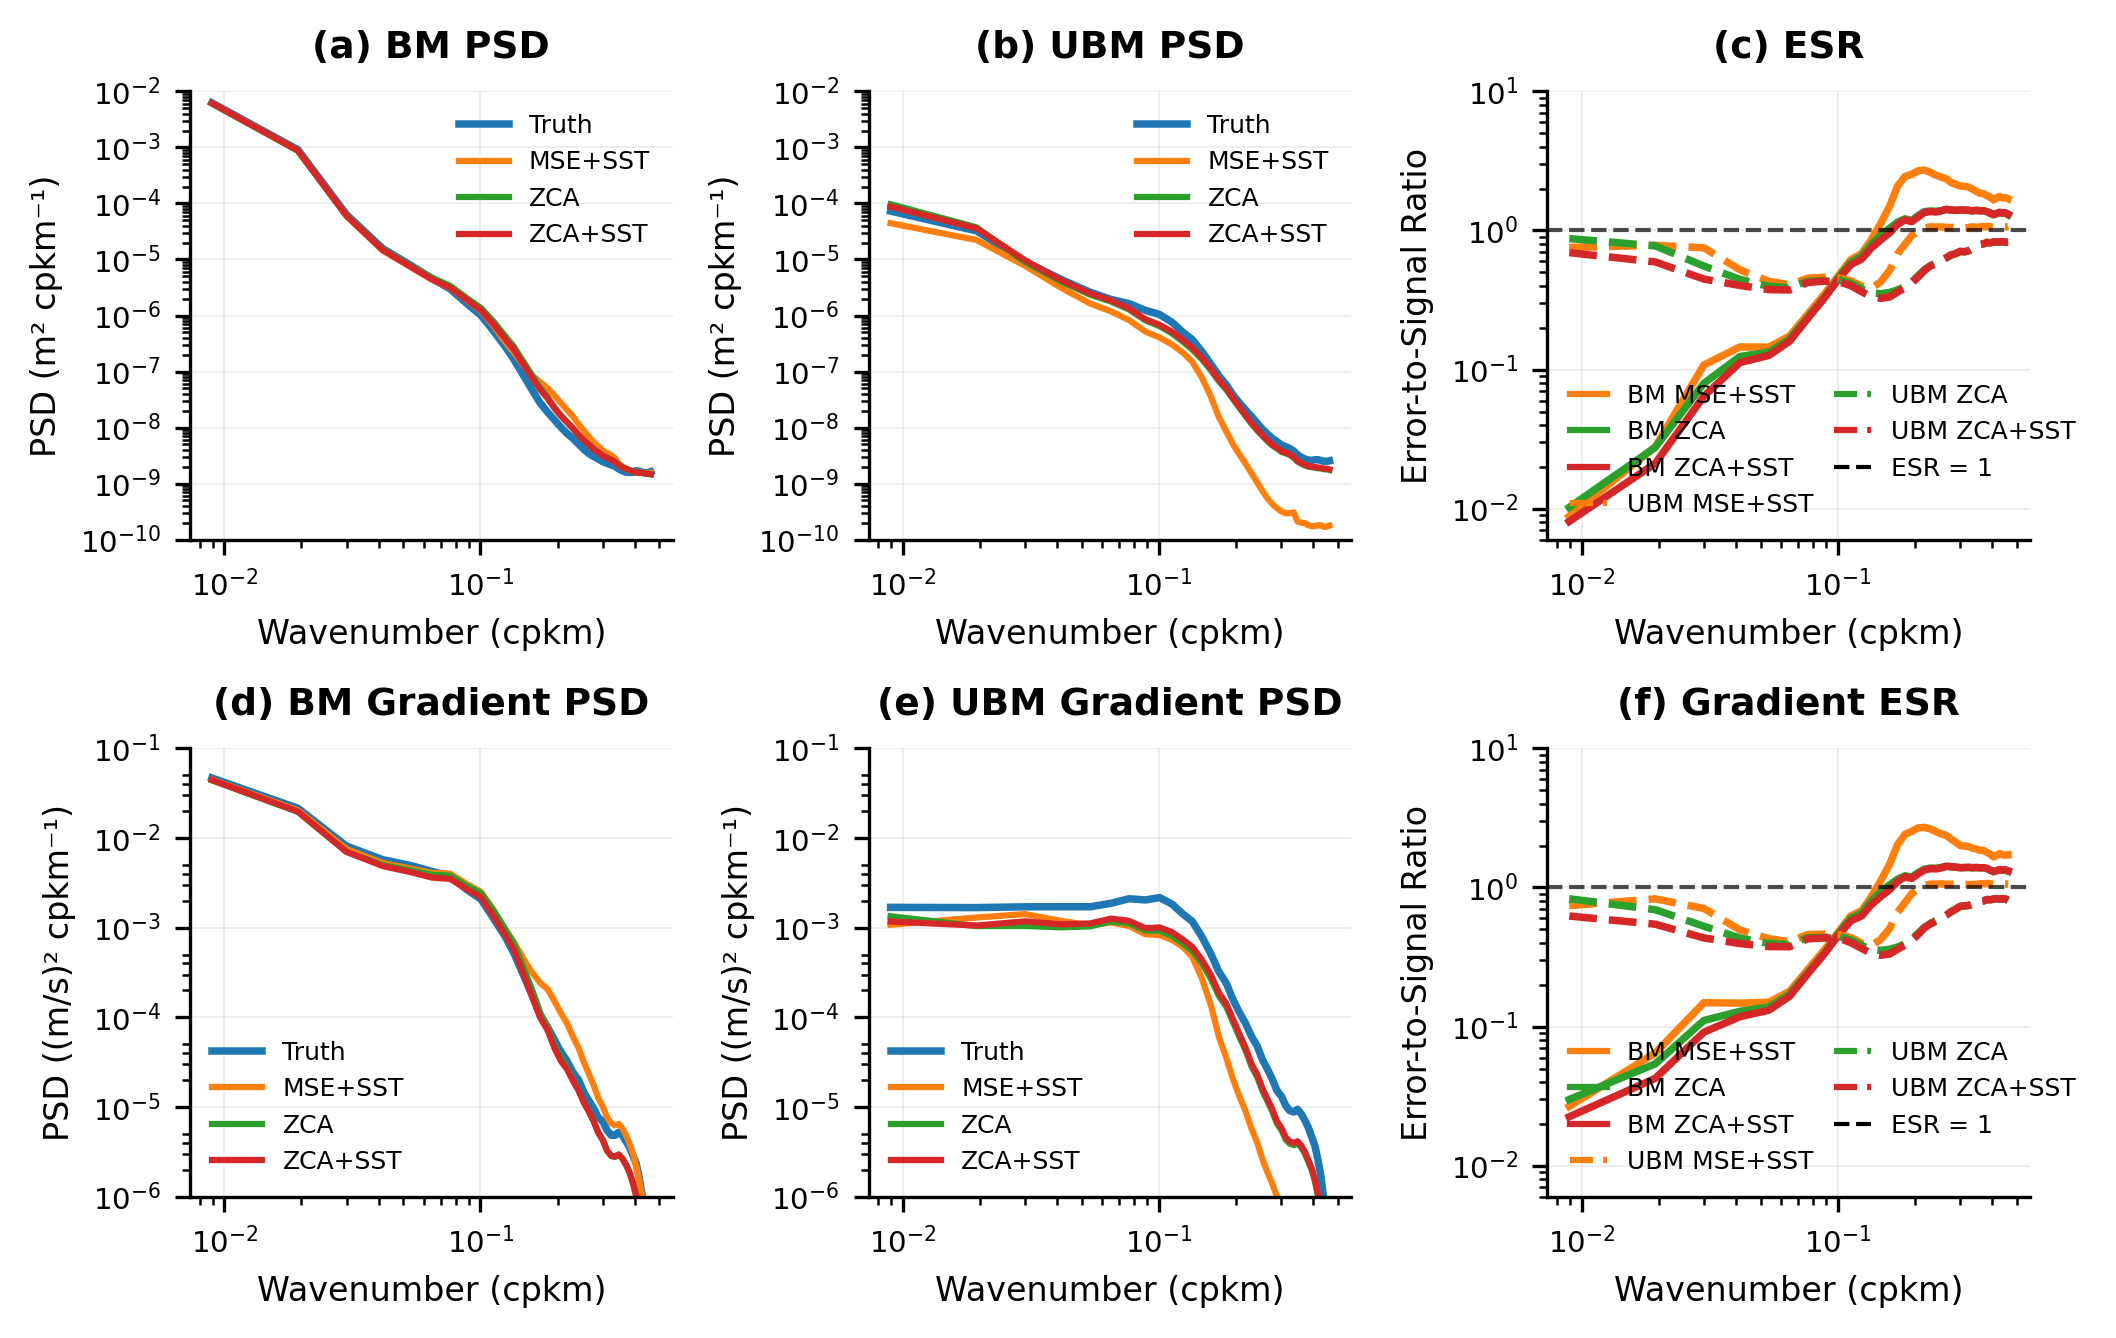

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.ticker import LogLocator

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

colors = {
    'true': '#1f77b4',      # Blue for truth
    'mse': '#ff7f0e',       # Orange for MSE baseline
    'zca': '#2ca02c',       # Green for ZCA 
    'zca_sst': '#d62728'    # Red for ZCA+SST
}


fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))
fig.subplots_adjust(wspace=0.35, hspace=0.45, left=0.08, right=0.98, top=0.95, bottom=0.08)


# Panel A: BM Power Spectral Density
ax1 = axes[0, 0]
PSD_bm_true.mean('sample').plot(ax=ax1, color=colors['true'], linewidth=1.8, label='Truth')
PSD_bm_mse.mean(['sample']).plot(ax=ax1, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_bm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_bm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Wavenumber (cpkm)')
ax1.set_ylabel('PSD (m² cpkm⁻¹)')
ax1.set_title('(a) BM PSD', fontweight='bold', pad=8)
ax1.grid(True, alpha=0.25, linewidth=0.4)
ax1.legend(frameon=False, fontsize=6)
ax1.set_ylim([1e-10, 1e-2])
ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))

# Panel B: UBM Power Spectral Density  
ax2 = axes[0, 1]
PSD_ubm_true.mean('sample').plot(ax=ax2, color=colors['true'], linewidth=1.8, label='Truth')
PSD_ubm_mse.mean(['sample']).plot(ax=ax2, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_ubm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_ubm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber (cpkm)')
ax2.set_ylabel('PSD (m² cpkm⁻¹)')
ax2.set_title('(b) UBM PSD', fontweight='bold', pad=8)
ax2.grid(True, alpha=0.25, linewidth=0.4)
ax2.legend(frameon=False, fontsize=6)
ax2.set_ylim([1e-10, 1e-2])
ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))

# Panel C: Combined BM and UBM Error-to-Signal Ratio
ax3 = axes[0, 2]

# Plot BM ESR (solid lines)
ESR_bm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='-', label='BM MSE+SST')
ESR_bm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='-', label='BM ZCA')
ESR_bm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='-', label='BM ZCA+SST')

# Plot UBM ESR (dashed lines) 
ESR_ubm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='--', label='UBM MSE+SST')
ESR_ubm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='--', label='UBM ZCA')
ESR_ubm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='--', label='UBM ZCA+SST')

# Add ESR = 1 reference line
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('Error-to-Signal Ratio')
ax3.set_title('(c) ESR', fontweight='bold', pad=8)
ax3.grid(True, alpha=0.25, linewidth=0.4)
ax3.set_ylim([6e-3, 10])

# Create custom legend for combined ESR plot
legend_elements = [
    # BM lines (solid)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='-', label='BM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='-', label='BM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='-', label='BM ZCA+SST'),
    # UBM lines (dashed)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='--', label='UBM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='--', label='UBM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='--', label='UBM ZCA+SST'),
    # Reference line
    plt.Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='ESR = 1')
]

ax3.legend(handles=legend_elements, frameon=False, ncol=2, fontsize=6, 
          handlelength=1.5, columnspacing=0.8, loc='best')


# Panel D: BM Velocity PSD (average of u and v)
ax4 = axes[1, 0]
PSD_vel_bm_true.mean('sample').plot(ax=ax4, color=colors['true'], linewidth=1.8, label='Truth')
PSD_vel_bm_mse.mean('sample').plot(ax=ax4, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_vel_bm_ssh.mean('sample').plot(ax=ax4, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_vel_bm_sst_ssh.mean('sample').plot(ax=ax4, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)')
ax4.set_ylabel('PSD ((m/s)² cpkm⁻¹)')
ax4.set_title('(d) BM Gradient PSD', fontweight='bold', pad=8)
ax4.grid(True, alpha=0.25, linewidth=0.4)
ax4.legend(frameon=False, fontsize=6)
ax4.set_ylim([1e-6, 1e-1])
ax4.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax4.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 6) * 0.1, numticks=100))

# Panel E: UBM Velocity PSD (average of u and v)
ax5 = axes[1, 1]
PSD_vel_ubm_true.mean('sample').plot(ax=ax5, color=colors['true'], linewidth=1.8, label='Truth')
PSD_vel_ubm_mse.mean('sample').plot(ax=ax5, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_vel_ubm_ssh.mean('sample').plot(ax=ax5, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_vel_ubm_sst_ssh.mean('sample').plot(ax=ax5, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Wavenumber (cpkm)')
ax5.set_ylabel('PSD ((m/s)² cpkm⁻¹)')
ax5.set_title('(e) UBM Gradient PSD', fontweight='bold', pad=8)
ax5.grid(True, alpha=0.25, linewidth=0.4)
ax5.legend(frameon=False, fontsize=6)
ax5.set_ylim([1e-6, 1e-1])
ax5.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax5.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 6) * 0.1, numticks=100))

# Panel F: Combined BM and UBM Velocity ESR
ax6 = axes[1, 2]

# Plot BM Velocity ESR (solid lines)
ESR_vel_bm_mse.plot(ax=ax6, color=colors['mse'], linewidth=1.8, linestyle='-', label='BM MSE+SST')
ESR_vel_bm_ssh.plot(ax=ax6, color=colors['zca'], linewidth=1.8, linestyle='-', label='BM ZCA')
ESR_vel_bm_sst_ssh.plot(ax=ax6, color=colors['zca_sst'], linewidth=1.8, linestyle='-', label='BM ZCA+SST')

# Plot UBM Velocity ESR (dashed lines)
ESR_vel_ubm_mse.plot(ax=ax6, color=colors['mse'], linewidth=1.8, linestyle='--', label='UBM MSE+SST')
ESR_vel_ubm_ssh.plot(ax=ax6, color=colors['zca'], linewidth=1.8, linestyle='--', label='UBM ZCA')
ESR_vel_ubm_sst_ssh.plot(ax=ax6, color=colors['zca_sst'], linewidth=1.8, linestyle='--', label='UBM ZCA+SST')

# Add ESR = 1 reference line
ax6.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel('Wavenumber (cpkm)')
ax6.set_ylabel('Error-to-Signal Ratio')
ax6.set_title('(f) Gradient ESR', fontweight='bold', pad=8)
ax6.grid(True, alpha=0.25, linewidth=0.4)
ax6.set_ylim([6e-3, 10])

# Create custom legend for combined velocity ESR plot
ax6.legend(handles=legend_elements, frameon=False, ncol=2, fontsize=6,
          handlelength=1.5, columnspacing=0.8, loc='best')

# Add overall figure improvements
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

plt.tight_layout()

plt.savefig('figures/publication_figure3.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()

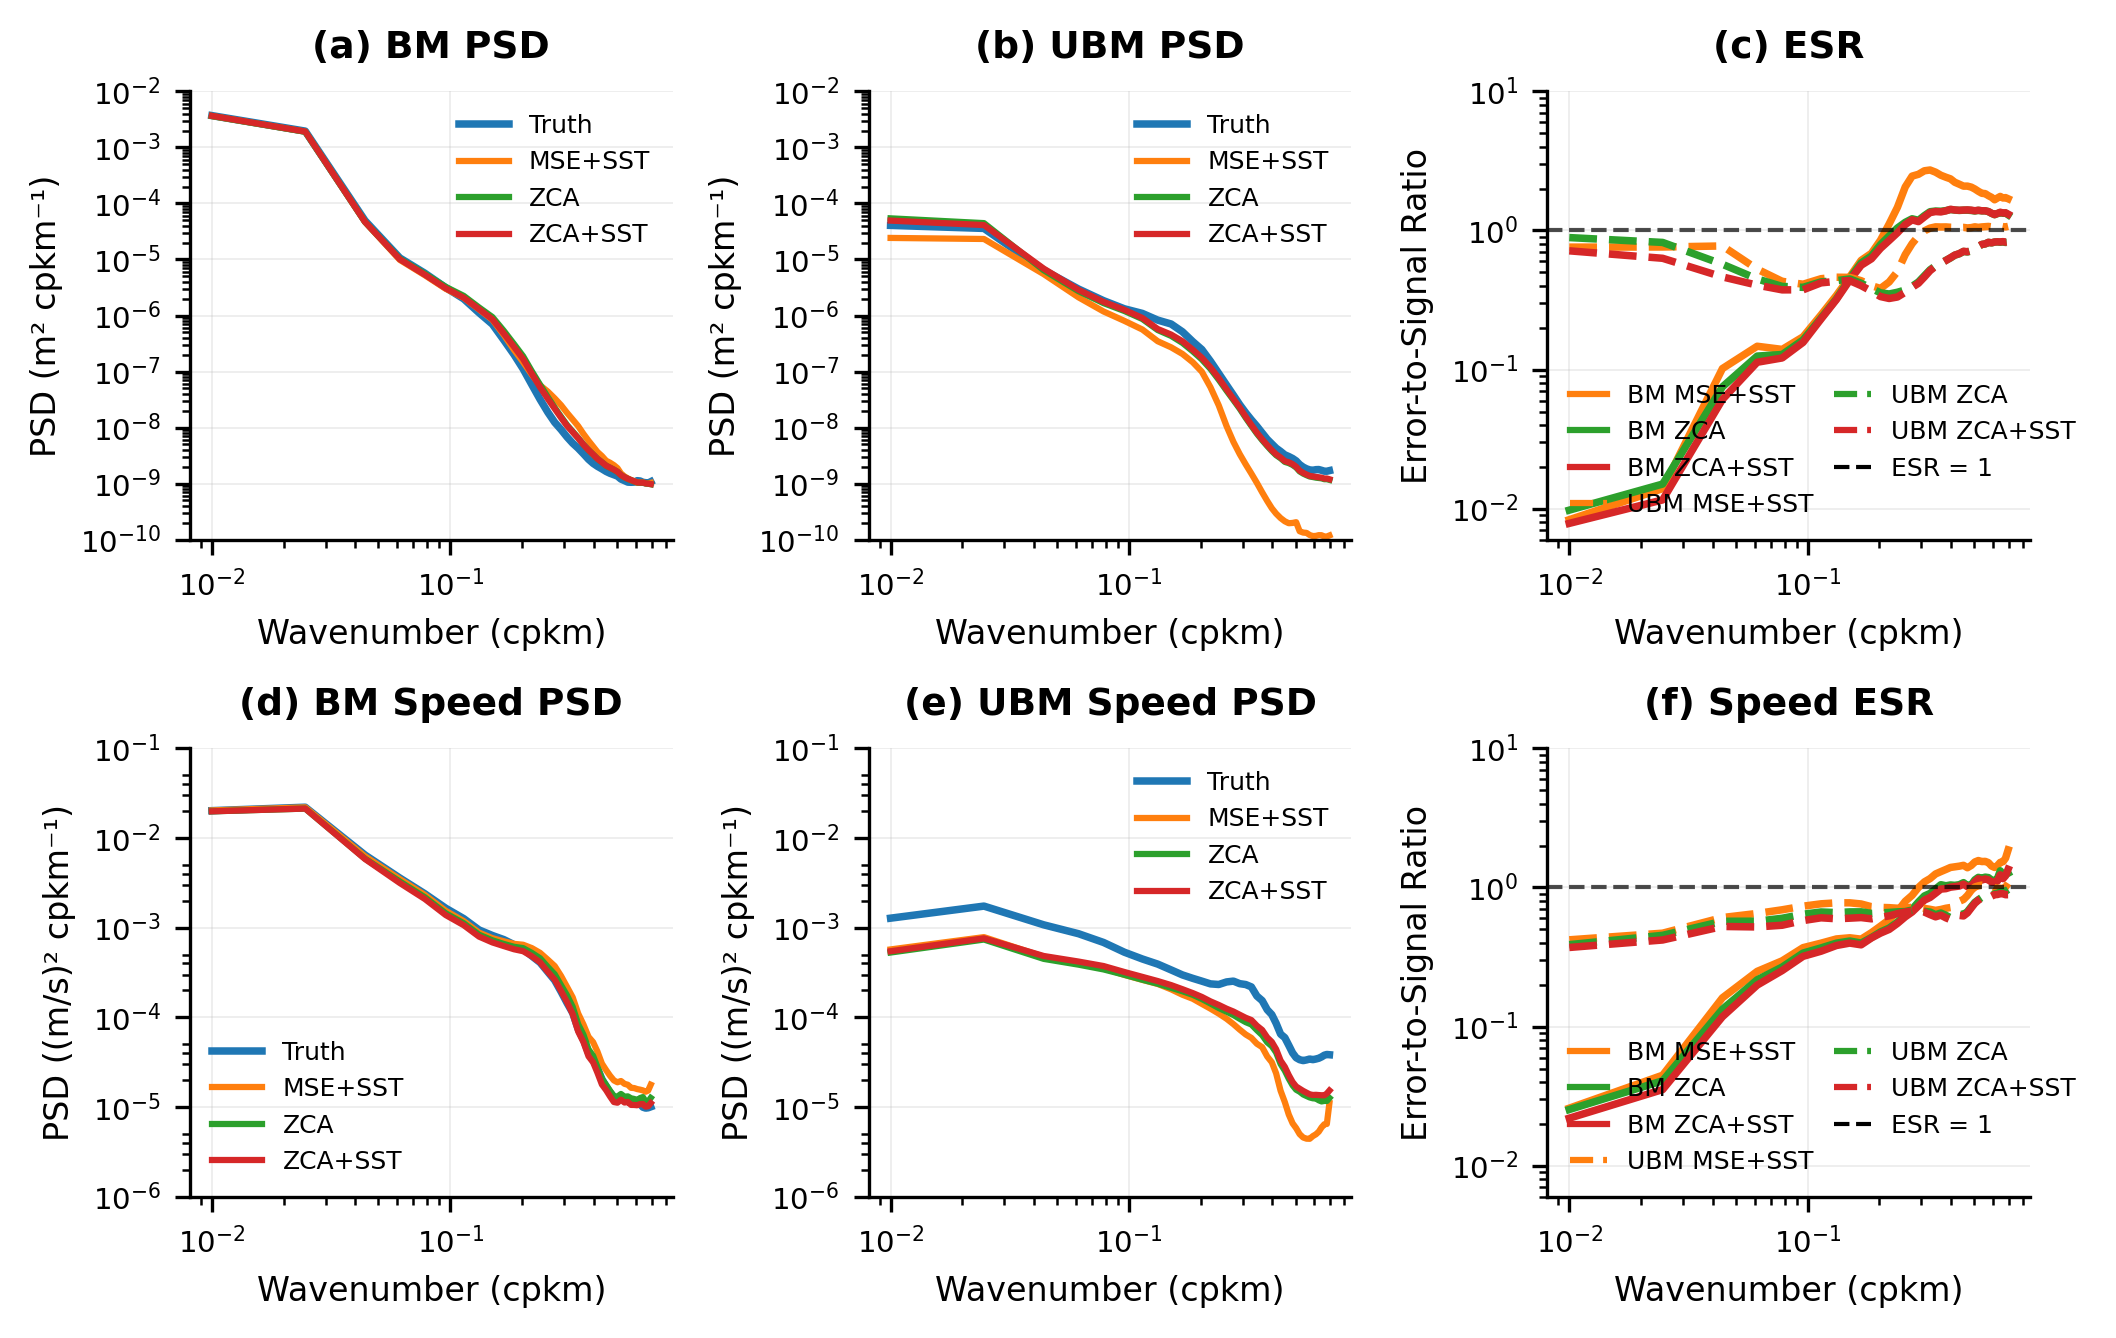

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.ticker import LogLocator

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 0.8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['axes.titlesize'] = 9
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300

colors = {
    'true': '#1f77b4',      # Blue for truth
    'mse': '#ff7f0e',       # Orange for MSE baseline
    'zca': '#2ca02c',       # Green for ZCA 
    'zca_sst': '#d62728'    # Red for ZCA+SST
}


fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))
fig.subplots_adjust(wspace=0.35, hspace=0.45, left=0.08, right=0.98, top=0.95, bottom=0.08)


# Panel A: BM Power Spectral Density
ax1 = axes[0, 0]
PSD_bm_true.mean('sample').plot(ax=ax1, color=colors['true'], linewidth=1.8, label='Truth')
PSD_bm_mse.mean(['sample']).plot(ax=ax1, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_bm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_bm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax1, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Wavenumber (cpkm)')
ax1.set_ylabel('PSD (m² cpkm⁻¹)')
ax1.set_title('(a) BM PSD', fontweight='bold', pad=8)
ax1.grid(True, alpha=0.25, linewidth=0.4)
ax1.legend(frameon=False, fontsize=6)
ax1.set_ylim([1e-10, 1e-2])
ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))

# Panel B: UBM Power Spectral Density  
ax2 = axes[0, 1]
PSD_ubm_true.mean('sample').plot(ax=ax2, color=colors['true'], linewidth=1.8, label='Truth')
PSD_ubm_mse.mean(['sample']).plot(ax=ax2, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_ubm_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_ubm_sst_ssh.mean(['sample','stochastic_sample']).plot(ax=ax2, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber (cpkm)')
ax2.set_ylabel('PSD (m² cpkm⁻¹)')
ax2.set_title('(b) UBM PSD', fontweight='bold', pad=8)
ax2.grid(True, alpha=0.25, linewidth=0.4)
ax2.legend(frameon=False, fontsize=6)
ax2.set_ylim([1e-10, 1e-2])
ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))

# Panel C: Combined BM and UBM Error-to-Signal Ratio
ax3 = axes[0, 2]

# Plot BM ESR (solid lines)
ESR_bm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='-', label='BM MSE+SST')
ESR_bm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='-', label='BM ZCA')
ESR_bm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='-', label='BM ZCA+SST')

# Plot UBM ESR (dashed lines) 
ESR_ubm_mse.plot(ax=ax3, color=colors['mse'], linewidth=1.8, linestyle='--', label='UBM MSE+SST')
ESR_ubm_ssh.plot(ax=ax3, color=colors['zca'], linewidth=1.8, linestyle='--', label='UBM ZCA')
ESR_ubm_sst_ssh.plot(ax=ax3, color=colors['zca_sst'], linewidth=1.8, linestyle='--', label='UBM ZCA+SST')

# Add ESR = 1 reference line
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('Error-to-Signal Ratio')
ax3.set_title('(c) ESR', fontweight='bold', pad=8)
ax3.grid(True, alpha=0.25, linewidth=0.4)
ax3.set_ylim([6e-3, 10])

# Create custom legend for combined ESR plot
legend_elements = [
    # BM lines (solid)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='-', label='BM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='-', label='BM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='-', label='BM ZCA+SST'),
    # UBM lines (dashed)
    plt.Line2D([0], [0], color=colors['mse'], linewidth=1.5, linestyle='--', label='UBM MSE+SST'),
    plt.Line2D([0], [0], color=colors['zca'], linewidth=1.5, linestyle='--', label='UBM ZCA'),
    plt.Line2D([0], [0], color=colors['zca_sst'], linewidth=1.5, linestyle='--', label='UBM ZCA+SST'),
    # Reference line
    plt.Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='ESR = 1')
]

ax3.legend(handles=legend_elements, frameon=False, ncol=2, fontsize=6, 
          handlelength=1.5, columnspacing=0.8, loc='best')


# Panel D: BM Geostrophic Speed PSD
ax4 = axes[1, 0]
PSD_speed_bm_true.mean('sample').plot(ax=ax4, color=colors['true'], linewidth=1.8, label='Truth')
PSD_speed_bm_mse.mean('sample').plot(ax=ax4, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_speed_bm_ssh.mean('sample').plot(ax=ax4, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_speed_bm_sst_ssh.mean('sample').plot(ax=ax4, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber (cpkm)')
ax4.set_ylabel('PSD ((m/s)² cpkm⁻¹)')
ax4.set_title('(d) BM Speed PSD', fontweight='bold', pad=8)
ax4.grid(True, alpha=0.25, linewidth=0.4)
ax4.legend(frameon=False, fontsize=6)
ax4.set_ylim([1e-6, 1e-1])
ax4.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax4.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 6) * 0.1, numticks=100))

# Panel E: UBM Geostrophic Speed PSD
ax5 = axes[1, 1]
PSD_speed_ubm_true.mean('sample').plot(ax=ax5, color=colors['true'], linewidth=1.8, label='Truth')
PSD_speed_ubm_mse.mean('sample').plot(ax=ax5, color=colors['mse'], linewidth=1.5, label='MSE+SST')
PSD_speed_ubm_ssh.mean('sample').plot(ax=ax5, color=colors['zca'], linewidth=1.5, label='ZCA')
PSD_speed_ubm_sst_ssh.mean('sample').plot(ax=ax5, color=colors['zca_sst'], linewidth=1.5, label='ZCA+SST')

ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('Wavenumber (cpkm)')
ax5.set_ylabel('PSD ((m/s)² cpkm⁻¹)')
ax5.set_title('(e) UBM Speed PSD', fontweight='bold', pad=8)
ax5.grid(True, alpha=0.25, linewidth=0.4)
ax5.legend(frameon=False, fontsize=6)
ax5.set_ylim([1e-6, 1e-1])
ax5.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax5.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 6) * 0.1, numticks=100))

# Panel F: Combined BM and UBM Speed ESR
ax6 = axes[1, 2]

# Plot BM Speed ESR (solid lines)
ESR_speed_bm_mse.plot(ax=ax6, color=colors['mse'], linewidth=1.8, linestyle='-', label='BM MSE+SST')
ESR_speed_bm_ssh.plot(ax=ax6, color=colors['zca'], linewidth=1.8, linestyle='-', label='BM ZCA')
ESR_speed_bm_sst_ssh.plot(ax=ax6, color=colors['zca_sst'], linewidth=1.8, linestyle='-', label='BM ZCA+SST')

# Plot UBM Speed ESR (dashed lines)
ESR_speed_ubm_mse.plot(ax=ax6, color=colors['mse'], linewidth=1.8, linestyle='--', label='UBM MSE+SST')
ESR_speed_ubm_ssh.plot(ax=ax6, color=colors['zca'], linewidth=1.8, linestyle='--', label='UBM ZCA')
ESR_speed_ubm_sst_ssh.plot(ax=ax6, color=colors['zca_sst'], linewidth=1.8, linestyle='--', label='UBM ZCA+SST')

# Add ESR = 1 reference line
ax6.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7, label='ESR = 1')

ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel('Wavenumber (cpkm)')
ax6.set_ylabel('Error-to-Signal Ratio')
ax6.set_title('(f) Speed ESR', fontweight='bold', pad=8)
ax6.grid(True, alpha=0.25, linewidth=0.4)
ax6.set_ylim([6e-3, 10])

# Create custom legend for combined speed ESR plot
ax6.legend(handles=legend_elements, frameon=False, ncol=2, fontsize=6,
          handlelength=1.5, columnspacing=0.8, loc='best')

# Add overall figure improvements
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

plt.tight_layout()

# plt.savefig('figures/figure_6panel_psd_esr_comparison.pdf', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', pad_inches=0.02)
# plt.savefig('figures/figure_6panel_psd_esr_comparison.eps', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', pad_inches=0.02)
plt.savefig('figures/figure_6panel_psd_esr_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none', pad_inches=0.02)

plt.show()

